In [1]:
import os
import argparse
from typing import List
from datetime import datetime
from dataclasses import dataclass
import data
import network
import solver
import joblib
import json
import torch

import matplotlib.pyplot as plt
import numpy as np
import time

## Gram-Schmidt Procerss to generate orthogonal W*s. 

In [2]:
def gram_schmidt(N, K):
    """
    Given the dimension space dimension N, generate K random vectors and its orthogonal spans
    """
    
    def proj(u,v):
        """
        Return projection of v to u
        """
        return np.dot(v,u)/np.dot(u,u) * u
    
    V=np.random.normal(loc = 0., scale = 1, size = (K, N))
    U=np.zeros_like(V)
    
    ## Initialise u1 to v1
    U[0] = V[0]
    
    ## Gram-schomidt process
    for k in range(1,K):
        projection_terms = [proj(U[i], V[k]) for i in range(k)]
        U[k] = V[k] - np.sum(projection_terms, axis=0)
    
    return V, U
        

def control_VS(VT, angle):
    dim = len(VT)
    VT_norm = VT/np.linalg.norm(VT)
    c = np.cos(angle)
    a = np.random.normal(loc = 0., scale = 1, size = (dim))
    b = np.random.normal(loc = 0., scale = 1, size = (dim))
    h = (b-a) - np.dot((b-a),VT_norm)*VT_norm
    v = np.cos(angle)*VT_norm + np.sin(angle)*h/np.linalg.norm(h)
    
    return v

## ODE


In [13]:
num_task = 4
seq_len = 1
input_dim = 1000
lr_ws=[0,0]
lr_v = 1
nums_iter =np.array([0,400000])
update_frequency = 1000


VT_nid = np.array([1.,1.,0.,0.])
VS_nid = control_VS(VT_nid, np.pi/2)

VT_id = VT_nid.copy()
VT_sim_id = VT_nid.copy()
VT_sim_nid = VT_nid.copy()


VS_id = VS_nid.copy()
VS_sim_id = VS_nid.copy()
VS_sim_nid = VS_nid.copy()


_, WT_nid =gram_schmidt(input_dim, num_task)
WT_id = WT_nid.copy()
WT_sim_id = WT_nid.copy()
WT_sim_nid = WT_nid.copy()

WS_nid = WT_nid.copy() + np.random.normal(loc = 0., scale = 0.001, size = (num_task, input_dim))
WS_id = WS_nid.copy()
WS_sim_id = WS_nid.copy()
WS_sim_nid = WS_nid.copy()



start = time.time()
ode_solver_id = solver.HRLODESolverIdentical(VS = VS_id, VT= VT_id, WS=WS_id, WT = WT_id, lr_ws = lr_ws, 
                                     lr_v=lr_v, seq_length= seq_len, N = input_dim)
ode_solver_id.train(nums_iter, update_frequency = update_frequency)
end = time.time()
print(f'Elapsed time: {end-start}')

In [14]:
start = time.time()
ode_solver_nid = solver.HRLODESolver(VS = VS_nid, VT= VT_nid, WS=WS_nid, WT = WT_nid, lr_ws = lr_ws, 
                                     lr_v=lr_v, seq_length= seq_len, N = input_dim)
ode_solver_nid.train(nums_iter, update_frequency = update_frequency)
end = time.time()
print(f'Elapsed time: {end-start}')

Elapsed time: 93.48202514648438


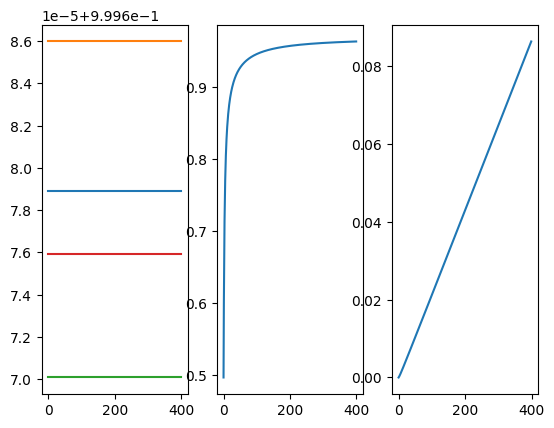

In [15]:
ax1 = plt.subplot(131)
p1=ode_solver_nid.history['phase1']['P']
p2=ode_solver_nid.history['phase2']['P']
ax1.plot(np.concatenate([p2]))

ax2 = plt.subplot(132)
p1=ode_solver_nid.history['phase1']['P_tilde']
p2=ode_solver_nid.history['phase2']['P_tilde']
ax2.plot(np.concatenate([p2]))

ax3 = plt.subplot(133)
s = ode_solver_nid.history['phase2']['VS']
t = ode_solver_nid.history['phase2']['VT']
ss = np.dot(s, t)/np.linalg.norm(s)/np.linalg.norm(t)
ax3.plot(ss)

In [16]:
ode_solver_nid.lr_w2=0.1
ode_solver_nid.lr_v = 1
ode_solver_nid.train(np.array([0,200000]), update_frequency = update_frequency)

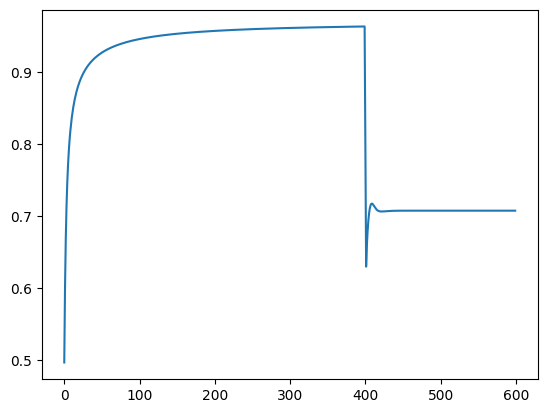

In [17]:
plt.plot(np.concatenate([p2, ode_solver_nid.history['phase2']['P_tilde']]))

In [18]:
composite_id=solver.simple_hrl_solver.CurriculumCompositionalTaskSimulator(input_dim = input_dim, seq_len = seq_len, 
                                                                       num_task = num_task, identical = True, WT = WT_sim_id, 
                                                                 WS=WS_sim_id, VT=VT_sim_id, VS=VS_sim_id  )

composite_nid=solver.simple_hrl_solver.CurriculumCompositionalTaskSimulator(input_dim = input_dim, seq_len = seq_len, 
                                                                       num_task = num_task, identical = False, WT = WT_sim_nid, 
                                                                 WS=WS_sim_nid, VT=VT_sim_nid, VS=VS_sim_nid  )

In [19]:
a = []
for i in range(100):
    x = np.random.normal(loc=0.0,
                     scale=1.0,
                     size=(4, 1000,4))
    (y, y_sign, y_hat, y_hat_sign), (y_tilde, y_tilde_hat,
                                                y_tilde_sign, y_tilde_hat_sign) =composite_nid.inference(x)
    
    a.append(np.all(y_tilde_sign == y_tilde_hat_sign))

In [20]:
start = time.time()
composite_nid.train(num_iter = nums_iter, update_frequency=update_frequency, lr={'lr_w':lr_ws[0],'lr_wc':lr_ws[1], 'lr_vc':lr_v})
end = time.time()
print(f'Elapsed time: {end-start}')

Elapsed time: 81.35681653022766


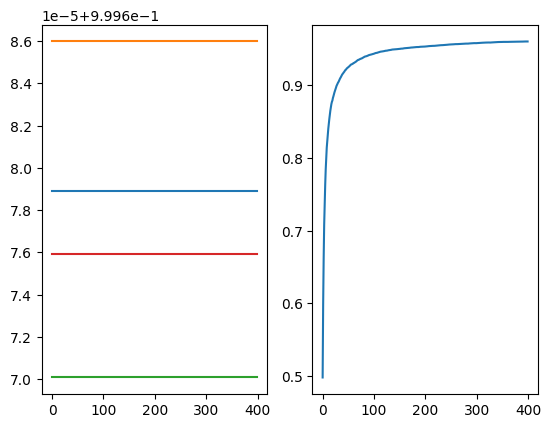

In [21]:
ax1 = plt.subplot(121)
psim2=composite_nid.history['P']
ax1.plot(np.concatenate([psim2]))

ax2 = plt.subplot(122)
ptsim2=composite_nid.history['P_tilde']
ax2.plot(np.concatenate([ptsim2]))


In [22]:
composite_nid.train(num_iter = [0,200000], update_frequency=update_frequency, lr={'lr_w':0,'lr_wc':0.1, 'lr_vc':1})


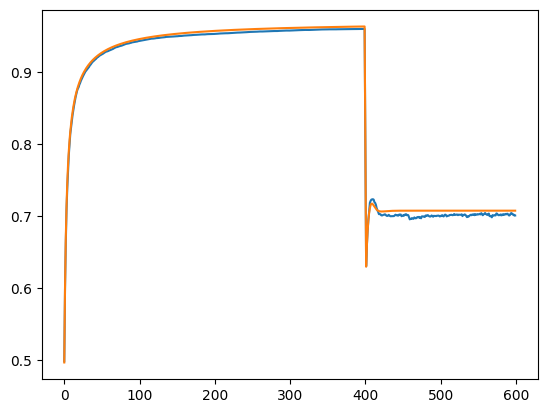

In [23]:
plt.plot(np.concatenate([ptsim2, composite_nid.history['P_tilde']]))
plt.plot(np.concatenate([p2, ode_solver_nid.history['phase2']['P_tilde']]))

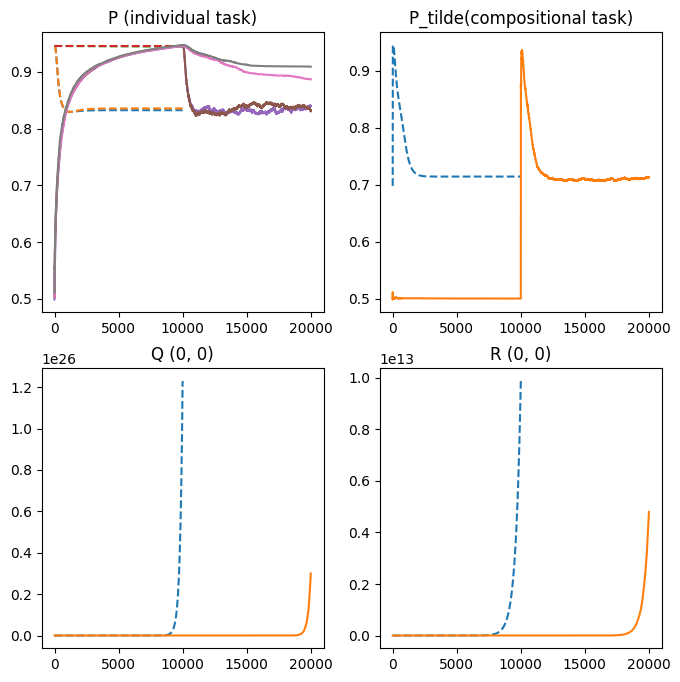

In [103]:

i,j = (0,0)
fig=plt.figure(figsize=(8,8))
ax1=plt.subplot(221)
ax1.set_title('P (individual task)')
ax1.plot(ode_solver_nid.history['phase2']['P'], ls= '--')
ax1.plot(composite_nid.history['P'])

ax2=plt.subplot(222)
ax2.set_title('P_tilde(compositional task)')
ax2.plot(ode_solver_nid.history['phase2']['P_tilde'], ls = '--')
ax2.plot(composite_nid.history['P_tilde'])

ax3=plt.subplot(223)
ax3.set_title(f'Q {i,j}')
ax3.plot(ode_solver_nid.history['phase2']['Q'][:,i,j], ls = '--')
ax3.plot(composite_nid.history['Q'][:,i,j])

ax4=plt.subplot(224)
ax4.set_title(f'R {i,j}')
ax4.plot(ode_solver_nid.history['phase2']['R'][:,i,j], ls = '--')
ax4.plot(composite_nid.history['R'][:,i,j])

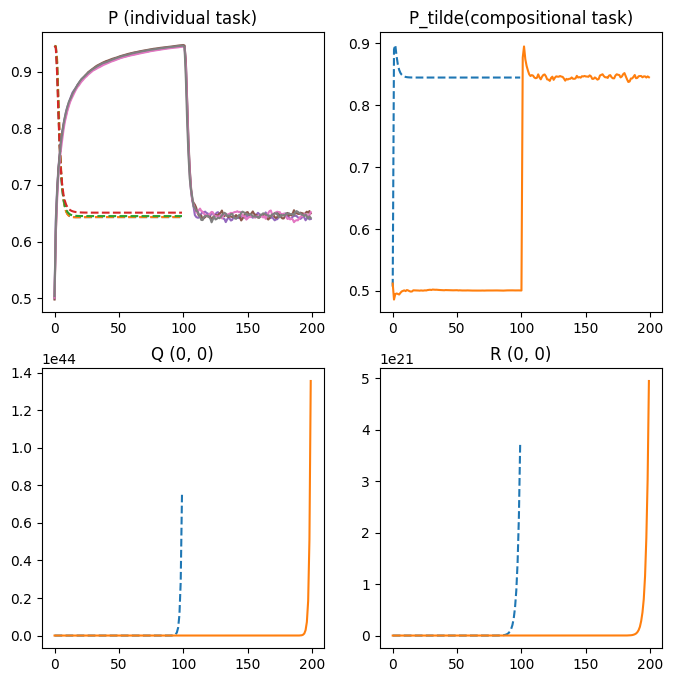

In [11]:

i,j = (0,0)
fig=plt.figure(figsize=(8,8))
ax1=plt.subplot(221)
ax1.set_title('P (individual task)')
ax1.plot(ode_solver_id.history['phase2']['P'], ls= '--')
ax1.plot(composite_id.history['P'])

ax2=plt.subplot(222)
ax2.set_title('P_tilde(compositional task)')
ax2.plot(ode_solver_id.history['phase2']['P_tilde'], ls = '--')
ax2.plot(composite_id.history['P_tilde'])

ax3=plt.subplot(223)
ax3.set_title(f'Q {i,j}')
ax3.plot(ode_solver_id.history['phase2']['Q'][:,i,j], ls = '--')
ax3.plot(composite_id.history['Q'][:,i,j])

ax4=plt.subplot(224)
ax4.set_title(f'R {i,j}')
ax4.plot(ode_solver_id.history['phase2']['R'][:,i,j], ls = '--')
ax4.plot(composite_id.history['R'][:,i,j])

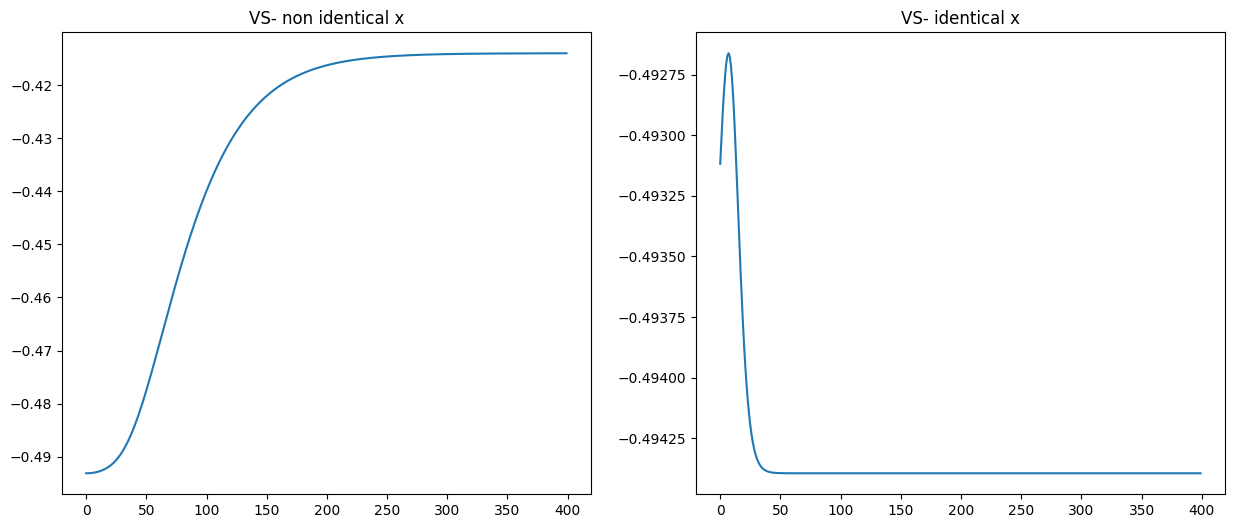

In [11]:

fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot(121)
ax1.set_title('VS- non identical x')
ax1.plot([np.dot(i,VT_id)/np.linalg.norm(i)/np.linalg.norm(VT_id) for i in ode_solver_nid.history['phase2']['VS']])
ax2 = plt.subplot(122)
ax2.set_title('VS- identical x')
ax2.plot([np.dot(i,VT_id)/np.linalg.norm(i)/np.linalg.norm(VT_id) for i in ode_solver_id.history['phase2']['VS']])